# ABS Quarterly Consumer Price Index 6401

## Python set-up

In [1]:
# analytic imports
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import matplotlib.patheffects as pe
import pandas as pd
import readabs as ra
from readabs import metacol as mc

In [2]:
# local imports
from abs_helper import (
    collate_summary_data,
    get_abs_data,
    ANNUAL_CPI_TARGET_RANGE,
    QUARTERLY_CPI_TARGET,
    QUARTERLY_CPI_RANGE,
)
from mgplot import (
    finalise_plot,
    line_plot_finalise,
    series_growth_plot_finalise,
    summary_plot_finalise,
    calc_growth
)
from henderson import hma

In [3]:
# pandas display settings
pd.options.display.max_rows = 999999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 100

# display charts in this notebook
SHOW = False
FILE_TYPE = "png"

## Get data from ABS

In [4]:
abs_dict, meta, source, RECENT = get_abs_data("6401.0")
plot_times = None, RECENT
plot_tags = "", "-recent"

In [5]:
meta[mc.table].unique()

array(['640101', '640102', '640103', '640104', '640105', '640106',
       '640107', '640108', '640109', '640110', '640111', '640112'],
      dtype=object)

## Plot

In [6]:
TARGETS = {"axhspan": ANNUAL_CPI_TARGET_RANGE, "axhline": QUARTERLY_CPI_TARGET}

### Summary chart

In [7]:
def summarise() -> None:
    """Summarise the ABS data."""

    required = {
        # order from least to most important (ie. bottom to top)
        # chart label: (ABS series ID code, growth over n periods)
        "1Q growth: Tradable CPI": ("A2330526L", 1),
        "4Q growth: Tradable CPI": ("A2330526L", 4),
        "1Q growth: Non-tradable CPI": ("A2330571X", 1),
        "4Q growth: Non-tradable CPI": ("A2330571X", 4),
        "1Q growth: Goods component CPI": ("A2330616T", 1),
        "4Q growth: Goods component CPI": ("A2330616T", 4),
        "1Q growth: Services component CPI": ("A2330706W", 1),
        "4Q growth: Services component CPI": ("A2330706W", 4),
        "1Q growth: Headline CPI": ("A2325846C", 1),
        "4Q growth: Headline CPI": ("A2325846C", 4),
        "1Q growth: Headline CPI (SA)": ("A3604506F", 1),
        "4Q growth: Headline CPI (SA)": ("A3604506F", 4),
        "1Q growth: Weighted median CPI (SA)": ("A3604503X", 1),
        "4Q growth: Weighted median CPI (SA)": ("A3604503X", 4),
        "1Q growth: Trimmed mean CPI (SA)": ("A3604509L", 1),
        "4Q growth: Trimmed mean CPI (SA)": ("A3604509L", 4),
    }
    summary = collate_summary_data(required, abs_dict, meta)

    summary_plot_finalise(
        summary,
        plot_from=pd.Period("1995Q1"),
        title=f"Key inflation statistics for {abs_dict['640102'].index[-1]}",
        rfooter=source,
        lfooter="Australia. All values are percentages. "
        "Seasonally adjusted series are marked (SA). ",
        show=SHOW,
        file_type=FILE_TYPE,
    )


summarise()

### Headline / Trimmed Mean / Weighted Median - Annual+Quarterly

Also volatility

In [8]:
# Used for pattern matching retrieval
QUARTERLY_PHRASE = "Percentage Change from Previous Period"
ANNUAL_PHRASE = "Percentage Change from Corresponding Quarter of Previous Year"
INDEX_PHRASE = "Index Numbers"
AUS_PHRASE = "Australia"

In [9]:
def plot_volatility(
    store: dict[str, pd.Series], starts: dict[str, pd.Period], table: str
) -> None:
    """Plot the stability/volatility of the different quarterly CPI series."""

    # calculate the volatility/stability of the quarterly growth rates
    vol_from = pd.Series(starts).max() + 1
    frame = pd.DataFrame(store)
    frame = frame[frame.index >= vol_from]
    ddof = 1
    qv_series = frame.diff(periods=1).std(ddof=ddof)
    qc_series = pd.Series(
        {name: series.corr(series.shift(1)) for name, series in frame.items()}
    )

    # calculate and plot trends, calculate mean absolute errors, MAE and SD of AE
    hma_term = 9
    hma_frame = pd.DataFrame(
        [hma(frame[x], hma_term) for x in frame.columns], index=frame.columns
    ).T
    for col in hma_frame.columns:
        svt = pd.DataFrame(
            [frame[col], hma_frame[col]],
            index=[
                "Series - quarter on quarter growth rate",
                f"{hma_term}-term Henderson moving average",
            ],
        ).T
        title = col.replace("Seasonally Adjusted", "(SA)").replace("Original", "(Orig)")
        ax: None | Axes = None
        for col, lw, color in zip(svt.columns, (1, 2), ("darkorange", "blue")):
            ax = svt[col].plot(lw=lw, color=color, label=col, ax=ax)
        if ax is None:
            continue
        ax.text(
            x=svt.index[-1],
            y=svt.iat[-1, 1],
            s=f" {svt.iat[-1, 1]:.2f}",
            color="blue",
            fontsize="x-small",
        )
        finalise_plot(
            ax,
            title=f"Series v Trend: {title}",
            ylabel="Per cent per quarter",
            axhspan=QUARTERLY_CPI_RANGE,
            rfooter=f"{source} {table}",
            lfooter="Australia. Growth rates calculated from the raw index. ",
            legend={"loc": "best", "fontsize": "x-small"},
            y0=True,
            show=SHOW,
            file_type=FILE_TYPE,
        )
    absolute_errors = (frame - hma_frame).abs()
    q_mae_series = absolute_errors.mean().sort_values()
    q_maesd_series = absolute_errors.std(ddof=1).sort_values()

    # utility plotting function
    def start_plotting(s: pd.Series) -> Axes:
        color = "cornflowerblue"
        s = s.sort_values()
        names = {
            x: x.replace("Seasonally Adjusted", "(SA)").replace("Original", "(Orig)")
            for x in s.index
        }
        s = s.rename(index=names)
        ax = s.plot.barh(color=color)
        for y, x in enumerate(s.values):
            t = ax.text(
                0.01, y, f"{x:.2f}", color="white", va="center", fontsize="xx-small"
            )
            t.set_path_effects([pe.withStroke(linewidth=1, foreground=color)])
        ax.set_yticklabels(s.index, fontsize="x-small")
        return ax

    # plot degree of autocorrelation in the quarterly growth rates
    ax = start_plotting(qc_series)
    finalise_plot(
        ax,
        title="Stability of Quarterly CPI Measures",
        xlabel="Pearson correlation for the quarterly growth\n"
        "rate and that for the previous quarter",
        ylabel=None,
        rfooter=f"{source} {table}",
        lfooter="Australia. Growth rates calculated from the raw index. "
        f"Data from {vol_from} to {frame.index[-1]}. "
        "Higher is better. ",
        show=SHOW,
        file_type=FILE_TYPE,
    )

    # plot the volatility of the quarterly growth rate series
    ax = start_plotting(qv_series)
    finalise_plot(
        ax,
        title="Volatility of Quarterly CPI Measures",
        xlabel="Standard deviation of first differences for\n"
        "quarterly CPI growth rates (percentage points)",
        ylabel=None,
        rfooter=f"{source} {table}",
        lfooter="Australia. Growth rates calculated from the raw index. "
        f"Std. Dev. DoF={ddof}. "
        f"Data from {vol_from} to {frame.index[-1]}. "
        "Lower is better. ",
        show=SHOW,
        file_type=FILE_TYPE,
    )

    # plot mean absolute error between the series and the trend
    ax = start_plotting(q_mae_series)
    finalise_plot(
        ax,
        title="Mean Absolute Error\nfor Quarterly CPI Measures",
        xlabel="Mean absolute error between the series and\n"
        f"the {hma_term}-term Henderson moving average",
        ylabel=None,
        rfooter=f"{source} {table}",
        lfooter="Australia. Growth rates calculated from the raw index. "
        f"Std. Dev. DoF={ddof}. "
        f"Data from {vol_from} to {frame.index[-1]}. "
        "Lower is better. ",
        show=SHOW,
        file_type=FILE_TYPE,
    )

    # plot standard deviation of the absolute errors between the series and the trend
    ax = start_plotting(q_maesd_series)
    finalise_plot(
        ax,
        title="Distribution of Absolute Errors\nfor Quarterly CPI Measures",
        xlabel="Std. Dev. of absolute errors between series\n"
        f"and the {hma_term}-term Henderson moving average",
        ylabel=None,
        rfooter=f"{source} {table}",
        lfooter="Australia. Growth rates calculated from the raw index. "
        f"Std. Dev. DoF={ddof}. "
        f"Data from {vol_from} to {frame.index[-1]}. "
        "Lower is better. ",
        show=SHOW,
        file_type=FILE_TYPE,
    )

In [10]:
def analytic_charts():
    """Produce charts for the analytic series:
    - Annualised growth rates for selected CPI series
    - Annual and quarterly growth rates for selected CPI series
    - Annual and quarterly growth rates for selected CPI series calculated from the raw index
    - Volatility of the quarterly growth rates for selected CPI series."""

    # set-up
    phrases = (ANNUAL_PHRASE, QUARTERLY_PHRASE, INDEX_PHRASE)
    starts, store = {}, {}
    table = "640106"
    data_t8 = abs_dict[table]
    wanted_charts = [
        ("Trimmed Mean", "Seasonally Adjusted"),
        ("Weighted Median", "Seasonally Adjusted"),
        ("All groups CPI ;  Australia", "Original"),  # Headline CPI
        ("All groups CPI", "Seasonally Adjusted"),  # Headline CPI seasonally adjusted
        ("All groups CPI excluding 'volatile items'", "Original"),
        ("All groups CPI excluding food and energy", "Original"),
        ("All groups, goods component", "Original"),
        ("All groups, services component", "Original"),
        ("Tradables", "Original"),
        ("Non-tradables", "Original"),
    ]
    for index, (label, series_type) in enumerate(wanted_charts):
        print(f"Processing {label} {series_type} {table}")
        title = f"CPI: {label}"

        # select data series identifiers
        a_id, q_id, i_id = [
            ra.find_abs_id(
                meta,
                {
                    table: mc.table,
                    series_type: mc.stype,
                    phrase: mc.did,
                    label: mc.did,
                },
            )[
                1
            ]  # the second element is the identifier
            for phrase in phrases
        ]

        # plot the annualised growth rates using ABS publised data
        comparative = pd.DataFrame(
            (data_t8[a_id], ra.annualise_percentages(data_t8[q_id], periods_per_year=4)),
            index=("Annual rate", "Quarterly annualised rate"),
        ).T
        line_plot_finalise(
            comparative[pd.Period("1970Q1", freq="Q") :],
            title=f"{title} (annualised)",
            ylabel="Per cent per year",
            y0=True,
            tag="annual-v-annualised",
            pre_tag=f"main-{index}-",
            axhspan=ANNUAL_CPI_TARGET_RANGE,
            rfooter=f"{source} {table}",
            lfooter=f"Australia. {series_type.capitalize()} series. ",
            width=(1.5, 2),
            show=SHOW,
            file_type=FILE_TYPE,
        )

        # plot annual and quarterly growth rates using ABS published data
        for plot_from, plot_tag in zip(plot_times, plot_tags):
            p_plot_from = (
                None
                if plot_from is None
                else pd.Period(plot_from, freq=data_t8.index.freq) # type: ignore[index]
            )

        # plot growth rates calculated from the ABS raw index (more precision)
        raw_index = data_t8[i_id]
        series_growth_plot_finalise(
            raw_index,
            plot_from=-19,
            title=f"{title}",
            **TARGETS, # type: ignore[arg-type]
            rfooter=f"{source} {table}",
            lfooter=f"Australia. {series_type.capitalize()} series. "
            + "Growth rates calculated from the raw index. ",
            #annotation_rounding=2,
            show=SHOW,
            file_type=FILE_TYPE,
        )

        # collect data for volatility/stability analysis
        name = f"{label} {series_type}"
        growth_df = calc_growth(raw_index)
        store[name] = growth_df[growth_df.columns[1]]
        starts[name] = raw_index.first_valid_index()

    plot_volatility(store, starts, table)


analytic_charts()

Processing Trimmed Mean Seasonally Adjusted 640106
Processing Weighted Median Seasonally Adjusted 640106
Processing All groups CPI ;  Australia Original 640106
Processing All groups CPI Seasonally Adjusted 640106
Processing All groups CPI excluding 'volatile items' Original 640106
Processing All groups CPI excluding food and energy Original 640106
Processing All groups, goods component Original 640106
Processing All groups, services component Original 640106
Processing Tradables Original 640106
Processing Non-tradables Original 640106


### TM and WM - 6 months annualised

[Early warning / test options around the next print.]

In [11]:
def core_annualised(
    fake_next: float | None = None,
    periods: int = 2,
) -> None:
    """Plot the annual or annualised growth rates for the core
    inflation series.
    Arguments:
    fake_next: float | None - if not None, this is the anticipated
                next quarter Q/Q growth rate.  It is useful for
                showing an anticipated growth rate on the chart.
    periods: int - the number of periods over which to annualise growth
                (should be in the range 1 .. 4).
                Four periods represents simple annual growth.
    Retuens: None."""

    # -- set-up
    expected = (1, 2, 3, 4)
    assert periods in expected, f"periods must be one of {expected}"
    annualise, months = 4 / periods, 3 * periods

    # -- calculate the annualised growth rates for the core inflation series
    table = "640106"
    wanted = [
        # "Index Numbers ;  All groups CPI, seasonally adjusted ;  Australia ;",
        "Index Numbers ;  Trimmed Mean ;  Australia ;",
        "Index Numbers ;  Weighted Median ;  Australia ;",
    ]
    df = pd.DataFrame()
    for w in wanted:
        selector = {
            table: mc.table,
            w: mc.did,
        }
        _table, s_id, _units = ra.find_abs_id(meta, selector)
        index = abs_dict[_table][s_id]

        foot = ""
        if fake_next is not None:
            next_index = index.index[-1] + 1  # type: ignore[operator]
            index.loc[next_index] = ((fake_next / 100) + 1) * index.iloc[-1]
            foot = f"Anticipated data for {next_index}: {fake_next}% Q/Q growth. "

        growth = ra.annualise_percentages(index.pct_change(periods) * 100, periods_per_year=annualise)
        df[w.replace("Index Numbers ;  ", "")] = growth

    # -- plot the annualised growth rates for the core inflation series
    foot += f"Endpoints: {df.iloc[-1].round(2).to_dict()}. "  # type: ignore[index]
    foot = foot.replace(" ;  Australia ;", "")
    title = f"Core Inflation: {months} months annualised growth".replace(
        "12 months annualised", "annual"
    )
    line_plot_finalise(
        df["2021Q1":],  # type: ignore[misc]
        width=2,
        title=title,
        ylabel="Per cent per year",
        axhspan=ANNUAL_CPI_TARGET_RANGE,
        rfooter=f"{source} {table}",
        lfooter=f"Seasonally Adjusted. {foot}",
        show=SHOW,
        file_type=FILE_TYPE,
    )


core_annualised()

### Analytical annual series - comparisons

In [12]:
def analytic_annual():
    """Produce charts for analytic data."""

    table = "640106"
    data = abs_dict[table]
    stem = "Percentage Change from Corresponding Quarter of Previous Year ;  "
    post = " ;  Australia ;"
    groups = [
        ["Tradables", "Non-tradables"],
        ["Original", "Seasonally Adjusted"],
        ["Goods", "Services"],
        ["Trimmed Mean", "Weighted Median"],
        ["Original", "Trimmed Mean"],
    ]

    # manage long/ugly names
    replacements = {
        "Goods": "All groups, goods component",
        "Services": "All groups, services component",
        "Original": "All groups CPI",
        "Seasonally Adjusted": "All groups CPI, seasonally adjusted",
    }

    for dataset in groups:
        idents = []
        for title in dataset:
            title = replacements.get(title, title)
            description = f"{stem}{title}{post}"
            series_type = (
                "Seasonally Adjusted"
                if "season" in title or "Trimmed" in title or "Weighted" in title
                else "Original"
            )
            search = {
                table: mc.table,
                description: mc.did,
                series_type: mc.stype,
            }
            table, ident, _ = ra.find_abs_id(meta, search)
            idents.append(ident)

        for start, tag in zip(plot_times, plot_tags):
            df = (
                data[data.index >= pd.Period(start, freq=data.index.freq)]  # type: ignore[index]
                if start
                else data
            )
            pair = df[idents]
            pair = pair.dropna(how="all", axis=0)
            pair.columns = dataset
            pair = pair.dropna(how="any", axis=0)  # compare where we can
            ax = pair.plot(lw=2, color=["blue", "darkorange"])
            finalise_plot(
                ax,
                title=f'CPI: {", ".join(dataset)}',
                ylabel="YoY Growth (per cent)",
                tag=tag,
                axhspan=ANNUAL_CPI_TARGET_RANGE,
                legend={"loc": "best", "fontsize": "x-small"},
                rfooter=f"{source} {table}",
                lfooter="Australia. Per cent change from same quarter in previous year",
                show=SHOW,
                file_type=FILE_TYPE,
            )


analytic_annual()

### Expenditure groups, sub-groups and classes

#### Map of groups, sub-groups, classses

In [13]:
expenditure_groups = {
    "Food and non-alcoholic beverages",
    "Alcohol and tobacco",
    "Clothing and footwear",
    "Housing",
    "Furnishings, household equipment and services",
    "Health",
    "Transport",
    "Communication",
    "Recreation and culture",
    "Education",
    "Insurance and financial services",
}

expenditure_sub_groups = {
    "Bread and cereal products",
    "Meat and seafoods",
    "Dairy and related products",
    "Fruit and vegetables",
    "Food products n.e.c.",
    "Non-alcoholic beverages",
    "Meals out and take away foods",
    "Alcoholic beverages",
    "Tobacco",
    "Garments",
    "Footwear",
    "Accessories and clothing services",
    "Rents",
    "New dwelling purchase by owner-occupiers",
    "Other housing",
    "Utilities",
    "Furniture and furnishings",
    "Household textiles",
    "Household appliances, utensils and tools",
    "Non-durable household products",
    "Domestic and household services",
    "Medical products, appliances and equipment",
    "Medical, dental and hospital services",
    "Private motoring",
    "Urban transport fares",
    "Communication",
    "Audio, visual and computing equipment and services",
    "Newspapers, books and stationery",
    "Holiday travel and accommodation",
    "Other recreation, sport and culture",
    "Education",
    "Insurance",
    "Financial services",
}

expenditure_classes = {
    "Bread",
    "Cakes and biscuits",
    "Breakfast cereals",
    "Other cereal products",
    "Beef and veal",
    "Pork",
    "Lamb and goat",
    "Poultry",
    "Other meats",
    "Fish and other seafood",
    "Milk",
    "Cheese",
    "Ice cream and other dairy products",
    "Fruit",
    "Vegetables",
    "Eggs",
    "Jams, honey and spreads",
    "Food additives and condiments",
    "Oils and fats",
    "Snacks and confectionery",
    "Other food products n.e.c.",
    "Coffee, tea and cocoa",
    "Waters, soft drinks and juices",
    "Restaurant meals",
    "Take away and fast foods",
    "Spirits",
    "Wine",
    "Beer",
    "Tobacco",
    "Garments for men",
    "Garments for women",
    "Garments for infants and children",
    "Footwear for men",
    "Footwear for women",
    "Footwear for infants and children",
    "Accessories",
    "Cleaning, repair and hire of clothing and footwear",
    "Rents",
    "New dwelling purchase by owner-occupiers",
    "Maintenance and repair of the dwelling",
    "Property rates and charges",
    "Water and sewerage",
    "Electricity",
    "Gas and other household fuels",
    "Furniture",
    "Carpets and other floor coverings",
    "Household textiles",
    "Major household appliances",
    "Small electric household appliances",
    "Glassware, tableware and household utensils",
    "Tools and equipment for house and garden",
    "Cleaning and maintenance products",
    "Personal care products",
    "Other non-durable household products",
    "Child care",
    "Hairdressing and personal grooming services",
    "Other household services",
    "Pharmaceutical products",
    "Therapeutic appliances and equipment",
    "Medical and hospital services",
    "Dental services",
    "Motor vehicles",
    "Spare parts and accessories for motor vehicles",
    "Automotive fuel",
    "Maintenance and repair of motor vehicles",
    "Other services in respect of motor vehicles",
    "Urban transport fares",
    "Postal services",
    "Telecommunication equipment and services",
    "Audio, visual and computing equipment",
    "Audio, visual and computing media and services",
    "Books",
    "Newspapers, magazines and stationery",
    "Domestic holiday travel and accommodation",
    "International holiday travel and accommodation",
    "Equipment for sports, camping and open-air recreation",
    "Games, toys and hobbies",
    "Pets and related products",
    "Veterinary and other services for pets",
    "Sports participation",
    "Other recreational, sporting and cultural services",
    "Preschool and primary education",
    "Secondary education",
    "Tertiary education",
    "Insurance",
    "Deposit and loan facilities (direct charges)",
    "Other financial services",
}

In [14]:
def category_checks():
    """sanity checks on above maps."""

    print(
        "Check count mapped items: "
        f"{len(expenditure_groups) + len(expenditure_sub_groups) + len(expenditure_classes)}"
    )

    # identify any missing
    table = "640105"
    search = {
        table: mc.table,
        AUS_PHRASE: mc.did,
        INDEX_PHRASE: mc.did,
    }
    rows = ra.search_abs_meta(meta, search)

    items = (
        rows[mc.did]
        .str.replace(";  Australia ;", "")
        .str.replace("Index Numbers ;", "")
        .str.strip()
    ).to_list()
    print(f"Check count ABS columns: {len(items)} - should be one more than above")

    print("Missing [should be only 'All groups CPI'] ...")
    for i in items:
        if (
            i not in expenditure_classes
            and i not in expenditure_sub_groups
            and i not in expenditure_groups
        ):
            print(i)

    clusters = (expenditure_groups, expenditure_sub_groups, expenditure_classes)
    for cluster in clusters:
        for element in cluster:
            if element not in items:
                print(cluster)


category_checks()

Check count mapped items: 131
Check count ABS columns: 132 - should be one more than above
Missing [should be only 'All groups CPI'] ...
All groups CPI


## plot trend lines

In [15]:
def get_cpi_index_elements(
    level: str = "class",
) -> pd.DataFrame:
    """Retrieve the CPI index elements at the specified level."""

    # set-up
    table = "640105"
    data = pd.DataFrame()

    # sanity checks
    levels = ("group", "sub-group", "class")
    if level not in levels:
        print(f"Warning: level should be one of {levels}")
        return data

    # compile DataFrame of required data items
    at_level = {
        "class": expenditure_classes,
        "sub-group": expenditure_sub_groups,
        "group": expenditure_groups,
    }[level]

    for cluster in at_level:
        id_selector = {
            table: mc.table,
            "Index Numbers": mc.did,
            cluster: mc.did,
        }

        _, series_id, _ = ra.find_abs_id(
            meta, search_terms=id_selector, validate_unique=False
        )
        data[cluster] = abs_dict[table][series_id]

    return data

In [16]:
def inflation_by_groups():
    """Plot CPI inflation by groups."""

    data = get_cpi_index_elements("group").sort_index(axis=1)
    if len(data) == 0:
        return  # no data
    pre_covid = pd.Period("2019-12-01", freq="Q")
    ten_years_ago = data.index[-1] - 40

    for span in ten_years_ago, pre_covid:
        select = data.div(data.loc[span]).mul(100)  # type: ignore[call-arg]
        select = select[select.index >= span]
        markers = " ", "o", "s", "d", "p", "*", "<", ">", "v", "^", "P", "X"
        line_plot_finalise(
            select,
            title=f"CPI Inflation by Groups (Index: {span}=100)",
            ylabel="Index",
            marker=markers,
            markersize=5,
            legend={"loc": "upper left", "fontsize": "xx-small", "ncols": 2},
            axhline={"y": 100, "color": "black", "linestyle": "--", "linewidth": 0.75},
            width=2,
            rfooter=source,
            lfooter="Australia. Original series.",
            show=SHOW,
            file_type=FILE_TYPE,
        )


inflation_by_groups()

#### Plot latest annual and quarterly growth by expenditure group

In [17]:
def get_cpi_growth_elements(
    level: str = "class", mode: str = "annual"
) -> pd.DataFrame | None:
    """Calculate expenditure growth by group, subgroup or class,
    for a quarter, through the year, or since COVID [Q4 2019]."""

    # sanity checks
    modes = ("annual", "quarterly", "post-covid")
    if mode not in modes:
        print(f"Warning: mode should be one of {modes}")
        return None

    data = get_cpi_index_elements(level)
    match mode:
        case "annual":
            periods = 4
        case "quarterly":
            periods = 1
        case "post-covid":
            start = pd.Period("2019Q4", freq="Q")
            periods = (data.index[-1] - start).n

    data = (data / data.shift(periods) - 1) * 100

    return data

In [18]:
def group_growth():
    """Bar chart of latest growth in CPI groups and sub-groups."""

    table = "7"
    for level in "group", "sub-group":
        figsize = (9.0, 10.0) if level == "sub-group" else (9.0, 4.5)
        for mode in "annual", "quarterly", "post-covid":
            data = get_cpi_growth_elements(level=level, mode=mode)
            if data is None or len(data) == 0:
                continue
            quarter = str(pd.Period(data.index[-1], freq="Q")).replace("Q", " Q")
            data = data.iloc[-1].sort_values()

            ax = data.plot.barh()
            title = f"{mode.capitalize()} Growth by\nCPI {level.capitalize()}"
            finalise_plot(
                ax,
                title=title,
                xlabel="Per cent",
                rfooter=f"{source} {table}",
                lfooter=f"Australia. {quarter}. Original series.",
                figsize=figsize,
                show=SHOW,
                file_type=FILE_TYPE,
            )


group_growth()

#### Plot top/bottom growing expenditure classes

In [19]:
def class_growth():
    """Bar chart of latest growth in expenditure classes."""

    top_keep = 30
    table = "7"

    for mode in "annual", "quarterly", "post-covid":
        data = get_cpi_growth_elements(level="class", mode=mode)
        if data is None:
            continue
        quarter = str(pd.Period(data.index[-1], freq="Q")).replace("Q", " Q")

        for tag in ("top", "last"):
            subset = (
                data.iloc[-1].sort_values(ascending=True)[-top_keep:]
                if tag == "top"
                else data.iloc[-1].sort_values(ascending=True)[:top_keep]
            )

            ax = subset.plot.barh()
            title = f"{mode.capitalize()} Growth by CPI\nExpenditure Class - {tag} {top_keep}"
            finalise_plot(
                ax,
                title=title,
                tag=tag,
                xlabel="Per cent",
                rfooter=f"{source} {table}",
                lfooter=f"Australia. {quarter}. "
                f"Note: there are {len(expenditure_classes)} expenditure classes",
                figsize=(9.0, 8.0),
                show=SHOW,
                file_type=FILE_TYPE,
            )


class_growth()

#### Breadth of inflation across CPI classes

In [20]:
def breadth_growth():
    """Chart the breadth of growth in CPI classes."""

    # set-up
    table = "7"
    annual_thresh = 3.0  # per cent - upper policy target
    # compound quarterisation ...
    qrtly_thresh = ((((annual_thresh / 100) + 1) ** 0.25) - 1) * 100

    for modality in "annual", "quarterly":
        # get the data
        data = get_cpi_growth_elements(level="class", mode=modality)
        if data is None or len(data) == 0:
            continue  # no data

        # calculate breadth
        thresh = annual_thresh if modality == "annual" else qrtly_thresh
        rounding = 1 if modality == "annual" else 3
        inflating_count = (data > thresh).sum(axis=1, skipna=True)
        total = data.notna().sum(axis=1)
        breadth = inflating_count / total * 100

        # plot results
        ax = breadth.plot(lw=2.5)
        finalise_plot(
            ax,
            title=f"CPI exp. classes with {modality} "
            f"price growth > {round(thresh, rounding)}%",
            ylabel="Per cent",
            rfooter=f"{source} {table}",
            lfooter="Australia. Original series. "
            "CPI expenditure classes only. "
            f"Endpoint: {breadth.iloc[-1]:0.2f}% of CPI expenditure classes. ",
            show=SHOW,
            file_type=FILE_TYPE,
        )


breadth_growth()

### Tails in CPI expenditure classes

In [21]:
def tails():
    """Chart tails in the CPI expenditure classes."""

    # set-up
    table = "640105"
    data = abs_dict[table]
    base_start = data.index[-1].year - 11

    for mode in "annual", "quarterly":
        data = get_cpi_growth_elements(level="class", mode=mode)
        if data is None or len(data) == 0:
            continue  # no data
        base = data[(data.index.year >= base_start)]  # type: ignore[misc]

        ax = base.T.quantile(q=[0.1, 0.5, 0.9], numeric_only=True).T.plot(lw=2.5)
        ax.legend(title="Quantiles", loc="upper left")
        finalise_plot(
            ax,
            title=f"{mode.capitalize()} Growth by CPI Expenditure Classes",
            tag="quartile",
            ylabel="Per cent",
            y0=True,
            rfooter=f"{source} {table}",
            lfooter="Australia. Original series. " "CPI expenditure classes only. ",
            show=SHOW,
            file_type=FILE_TYPE,
        )


tails()

In [22]:
def distro_plot(base: pd.DataFrame, bounds=None, **kwargs) -> None:
    """Produce distributional plots for the data.
    Assume **kwargs includes title, rfooter and lfooter."""

    bounds = 15 if bounds is None else bounds
    adj = base.median(axis=1).max()
    min_plot, max_plot = adj - bounds, bounds + adj
    min_data, max_data = base.min().min(), base.max().max()
    if min_data < min_plot or max_data > max_plot:
        min_plot, max_plot = max(min_plot, min_data), min(max_plot, max_data)
        kwargs["lfooter"] += "Larger outliers not plotted. "
    padding = 0.025
    adj = (max_plot - min_plot) * padding
    ylim = min_plot - adj, max_plot + adj

    ax = base.T.boxplot(rot=30)
    finalise_plot(
        ax,
        tag="box",
        ylabel="Per cent",
        ylim=ylim,
        show=SHOW,
        file_type=FILE_TYPE,
        **kwargs,
    )

In [23]:
def distro_recent(go_back_n_quarters: int = -20):
    """Chart recent N Quarters."""

    mode = "quarterly"
    data = get_cpi_growth_elements(level="class", mode=mode)
    if data is not None:
        base = data.iloc[go_back_n_quarters:]
        title = f"Distribution of {mode.capitalize()} Growth by CPI Exp. Class"
        rfooter = f"{source} 7"
        lfooter = "Australia. Original series. CPI expenditure classes only. "

        distro_plot(
            base,
            title=title,
            rfooter=rfooter,
            lfooter=lfooter,
            pre_tag="recent",
            axhline=QUARTERLY_CPI_TARGET,
            legend={"loc": "best", "fontsize": "x-small"},
        )

In [24]:
distro_recent()

In [25]:
def distro_q_on_q():
    """Chart comparisons with same quarter in previous years."""

    for mode in "annual", "quarterly":
        data = get_cpi_growth_elements(level="class", mode=mode)
        if data is None:
            continue  # no data
        base_start = data.index[-1].year - 11
        current_qtr = data.index[-1].quarter
        base = data[
            (data.index.year >= base_start) & (data.index.quarter == current_qtr)  # type: ignore[misc]
        ]
        title = f"Distribution of {mode.capitalize()} Growth by CPI Exp. Class"
        rfooter = f"{source} 7"
        lfooter = "Australia. Original series. CPI expenditure classes only. "
        bounds = 25 if mode == "annual" else 15

        distro_plot(
            base,
            bounds=bounds,
            title=title,
            rfooter=rfooter,
            lfooter=lfooter,
            axhline=QUARTERLY_CPI_TARGET,
            pre_tag="by-year",
            y0=True,
        )


distro_q_on_q()

## Exploratory

In [26]:
def get_classes() -> pd.DataFrame:
    """Get Index values for each expenditure class."""

    table = "640105"
    search = {
        table: mc.table,
        AUS_PHRASE: mc.did,
        INDEX_PHRASE: mc.did,
    }
    rows = ra.search_abs_meta(meta, search)
    rows.index = pd.Index(
        rows[mc.did]
        .str.replace(";  Australia ;", "")
        .str.replace("Index Numbers ;", "")
        .str.strip()
    )
    rows = rows[~rows.index.duplicated(keep="last")]
    classes = {}
    for item in expenditure_classes:
        sid = rows.loc[item, mc.id]
        classes[item] = abs_dict[table][sid]

    return pd.DataFrame(classes)

In [27]:
def get_cpi() -> pd.Series:
    """Get the headline CPI index."""

    table, cpi = "640101", "A2325846C"
    inflation = abs_dict[table][cpi]
    return inflation

### Residential

In [28]:
def residential():
    """Plot the annual price growth for Rents and New Dwelling Purchase by Owner-Occupiers."""

    c = get_classes()
    colors = ["blue", "darkorange"]
    cdiff = c[["Rents", "New dwelling purchase by owner-occupiers"]].diff(4)
    # annotate end points
    vas = (
        ["bottom", "top"]
        if cdiff.iloc[-1, 0] > cdiff.iloc[-1, 1]  # type: ignore[index]
        else ["top", "bottom"]
    )
    # plot lines and finalise
    line_plot_finalise(
        cdiff,
        width=2,
        color=colors,
        title="CPI: Rents and New Dwelling Purchase by Owner-Occupiers",
        ylabel="Per cent per year",
        rfooter=f"{source}",
        lfooter="Australia. Original series. ",
        y0=True,
        show=SHOW,
        annotate=True,
        file_type=FILE_TYPE,
    )

    # compare with inflation
    inflation=get_cpi().pct_change(4) * 100
    relative = cdiff.sub(inflation, axis=0)
    line_plot_finalise(
        relative,
        width=2,
        color=colors,
        title="Residential Costs Above/Below All Groups CPI Inflation",
        ylabel="Annual percentage points",
        rfooter=f"{source}",
        lfooter="Australia. Original series. ",
        y0=True,
        show=SHOW,
        annotate=True,
        file_type=FILE_TYPE,
    )


residential()

### Electricity

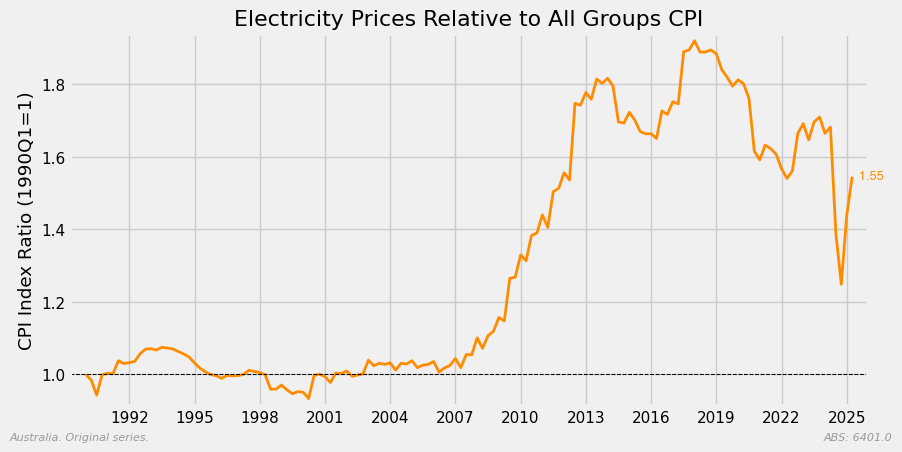

In [29]:
def electricity():
    """Plot electricity prices and compare with inflation."""

    cut_off = pd.Period("1990Q1", freq="Q")
    electricity = (
        get_classes()["Electricity"]
        .dropna()
        .loc[cut_off:]
    )
    inflation = (
        get_cpi()
        .dropna()
        .loc[cut_off:]
    )

    # plot index numbers: electricity v CPI
    frame = pd.DataFrame({"Electricity Price": electricity, "All Groups CPI": inflation})
    for col in frame:
        frame[col] = frame[col] / frame[col].iloc[0] * 100
    line_plot_finalise(
        frame,
        width=2,
        color=["darkorange", "blue"],
        title="Electricity Prices and All Groups CPI (Index numbers)",
        ylabel=f"Index ({cut_off}=100)",
        rfooter=source,
        lfooter="Australia. Original series. ",
        y0=True,
        show=SHOW,
        annotate=True,
        file_type=FILE_TYPE,
    )

    # plot ratio: electricity relative to CPI cf cut-off date
    multiplier = frame["Electricity Price"] / frame["All Groups CPI"]
    line_plot_finalise(
        multiplier,
        width=2,
        color=["darkorange"],
        title="Electricity Prices Relative to All Groups CPI",
        ylabel=f"CPI Index Ratio ({cut_off}=1)",
        rfooter=source,
        lfooter="Australia. Original series. ",
        axhline={"y": 1.0, "color": "black", "linestyle": "--", "linewidth": 0.75},
        show=True,
        annotate=True,
        file_type=FILE_TYPE,
    )


electricity()

## Finished

In [30]:
# watermark
%load_ext watermark
%watermark -u -t -d --iversions --watermark --machine --python --conda

Last updated: 2025-09-20 14:58:10

Python implementation: CPython
Python version       : 3.13.6
IPython version      : 9.4.0

conda environment: n/a

Compiler    : Clang 20.1.4 
OS          : Darwin
Release     : 24.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

pandas    : 2.3.1
mgplot    : 0.2.12
readabs   : 0.1.4
matplotlib: 3.10.5

Watermark: 2.5.0



In [31]:
print("Finished")

Finished
